In [1]:
!pip install -U -q pyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
id = "1hsPZJULl1m3N4VDff-OtyTnPubaR6rAY"
file = drive.CreateFile({'id':id})
file.GetContentFile('bank.data.csv')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.metrics import roc_curve
from sklearn import metrics

In [4]:
churn_df = pd.read_csv('bank.data.csv')
churn_df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Part 1: Data Exploration

In [5]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [6]:
# Check unique vals of each col
churn_df.nunique()

,0
RowNumber,10000
CustomerId,10000
Surname,2932
CreditScore,460
Geography,3
Gender,2
Age,70
Tenure,11
Balance,6382
NumOfProducts,4


In [7]:
# Check missing vals
churn_df.isnull().sum()

,0
RowNumber,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0


In [8]:
# Check numerical features
churn_df[['CreditScore', 'Age', 'Tenure', 'NumOfProducts', 'Balance', 'EstimatedSalary']].describe()

,CreditScore,Age,Tenure,NumOfProducts,Balance,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,1.530200,76485.889288,100090.239881
std,96.653299,10.487806,2.892174,0.581654,62397.405202,57510.492818
min,350.000000,18.000000,0.000000,1.000000,0.000000,11.580000
25%,584.000000,32.000000,3.000000,1.000000,0.000000,51002.110000
50%,652.000000,37.000000,5.000000,1.000000,97198.540000,100193.915000
75%,718.000000,44.000000,7.000000,2.000000,127644.240000,149388.247500
max,850.000000,92.000000,10.000000,4.000000,250898.090000,199992.480000


<Axes: xlabel='Exited', ylabel='EstimatedSalary'>

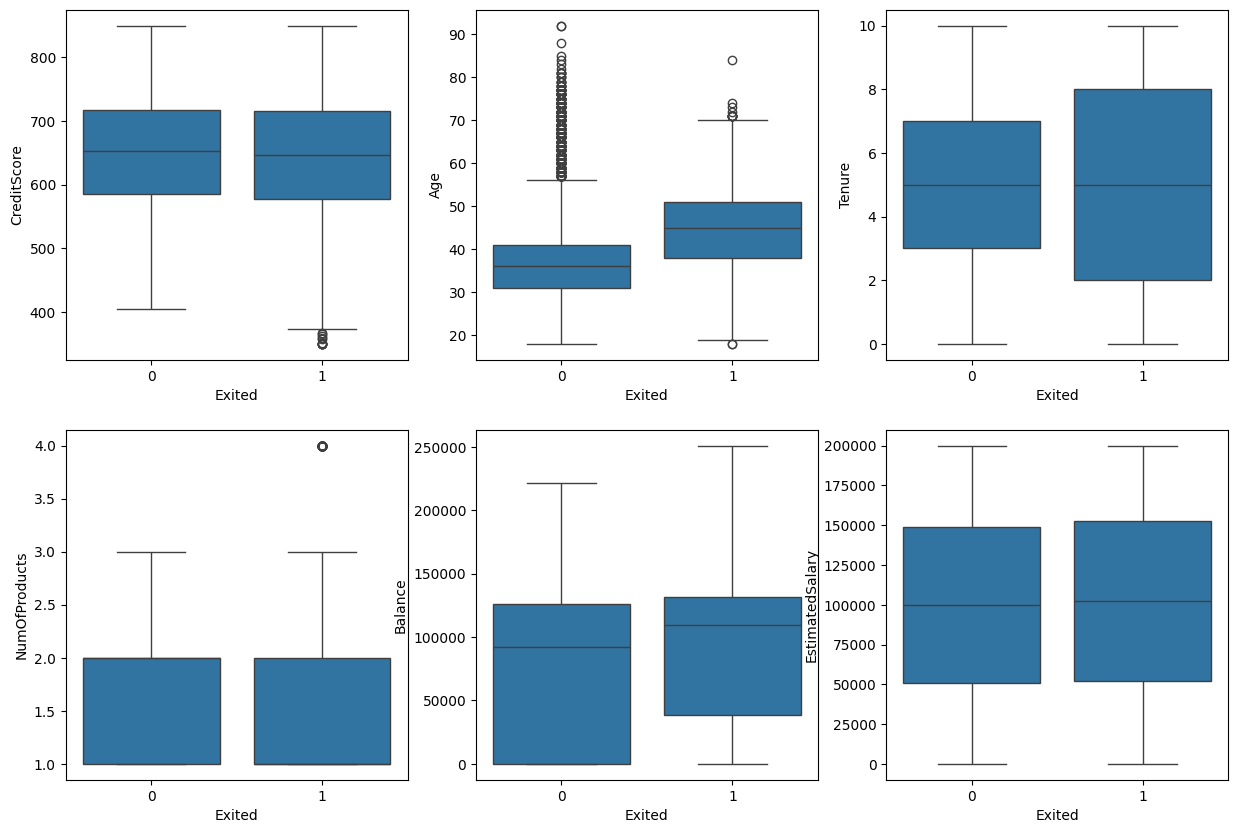

In [9]:
# Boxplot for numerical numbers
_, axss = plt.subplots(2, 3, figsize=(15, 10))
sns.boxplot(ax=axss[0, 0], data=churn_df, x='Exited', y='CreditScore')
sns.boxplot(ax=axss[0, 1], data=churn_df, x='Exited', y='Age')
sns.boxplot(ax=axss[0, 2], data=churn_df, x='Exited', y='Tenure')
sns.boxplot(ax=axss[1, 0], data=churn_df, x='Exited', y='NumOfProducts')
sns.boxplot(ax=axss[1, 1], data=churn_df, x='Exited', y='Balance')
sns.boxplot(ax=axss[1, 2], data=churn_df, x='Exited', y='EstimatedSalary')

<Axes: xlabel='Exited', ylabel='count'>

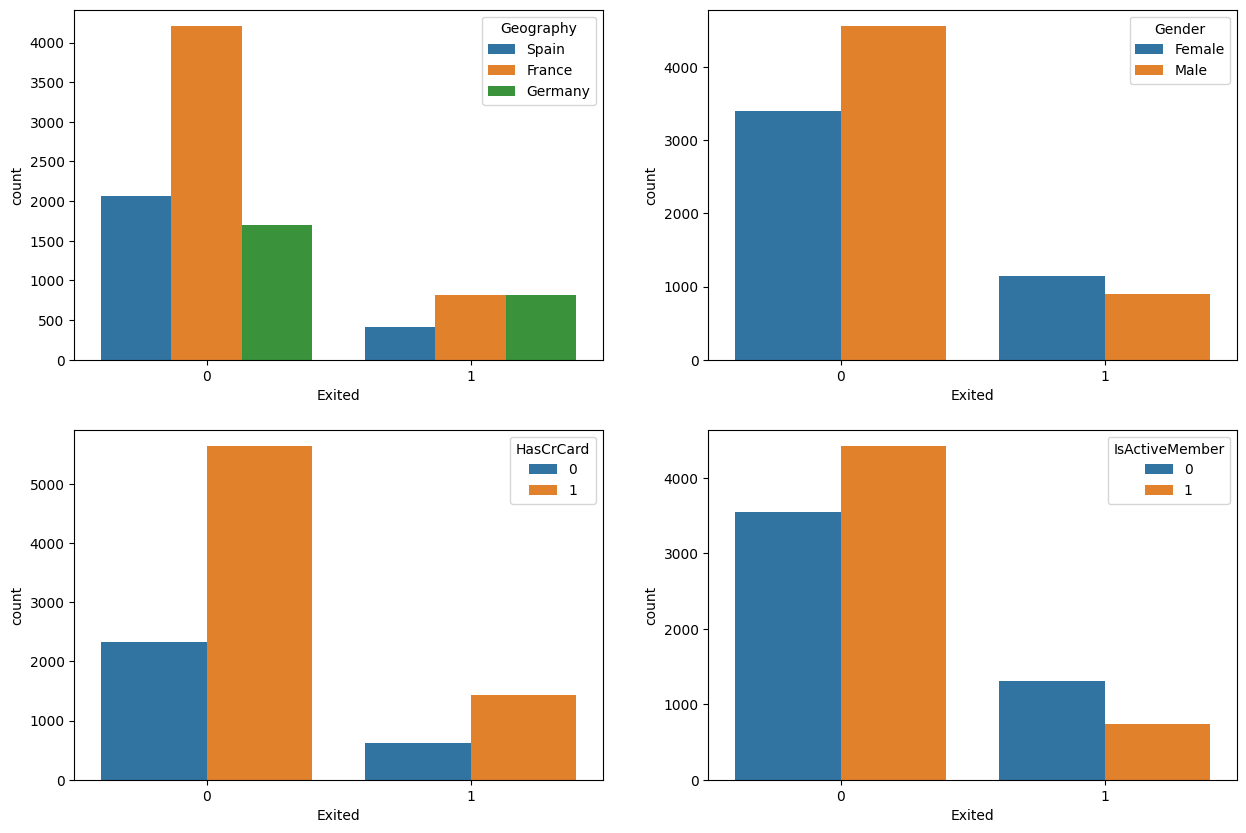

In [10]:
# Explore categorical features
_, axss = plt.subplots(2, 2, figsize=(15, 10))
sns.countplot(ax=axss[0, 0], data=churn_df, hue='Geography', x='Exited')
sns.countplot(ax=axss[0, 1], data=churn_df, hue='Gender', x='Exited')
sns.countplot(ax=axss[1, 0], data=churn_df, hue='HasCrCard', x='Exited')
sns.countplot(ax=axss[1, 1], data=churn_df, hue='IsActiveMember', x='Exited')

# Part 2: Feature Preprocessing

In [11]:
# Get target variable
y = churn_df['Exited']

# Get feature space and drop useless features
X = churn_df.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Exited'])

In [12]:
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [13]:
cat_cols = X.columns[X.dtypes == 'object']
num_cols = X.columns[X.dtypes != 'object']

In [14]:
# One hot encoding
def OneHotEncoding(df, enc, categories):
  transformed = pd.DataFrame(enc.fit_transform(df[categories]).toarray(), columns=enc.get_feature_names_out(categories))
  return pd.concat([df.reset_index(drop=True), transformed], axis=1).drop(columns=categories)

categories = ['Geography', 'Gender']
enc_ohe = OneHotEncoder()
enc_ohe.fit(X[categories])
X_processed = OneHotEncoding(X, enc_ohe, categories)

# categories = ['Gender']
# enc_oe = OrdinalEncoder()
# enc_oe.fit(X_train[categories])

# X_train[categories] = enc_oe.transform(X_train[categories])
# X_test[categories] = enc_oe.transform(X_test[categories])


In [15]:
# Split dataset
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_processed, y, test_size=0.25, stratify=y, random_state=1) # 25% testing

print('Train set: ', X_train.shape, y_train.shape)
print('Test set: ', X_test.shape, y_test.shape)

Train set:  (7500, 13) (7500,)
Test set:  (2500, 13) (2500,)


In [16]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
7971,633,42,10,0.00,1,0,1,79408.17,0.0,0.0,1.0,0.0,1.0
9152,708,23,4,71433.08,1,1,0,103697.57,0.0,1.0,0.0,1.0,0.0
6732,548,37,9,0.00,2,0,0,98029.58,1.0,0.0,0.0,1.0,0.0
902,645,48,7,90612.34,1,1,1,149139.13,1.0,0.0,0.0,1.0,0.0
2996,729,45,7,91091.06,2,1,0,71133.12,0.0,0.0,1.0,1.0,0.0


In [17]:
# Standardize / Normalize Data

# Standardization: (x - mean) / std
# Normalization: (x - m_min) / (m_max - m_min)

# Speed up gradient descent
# Same scale
# Algorithm requirements

scaler = StandardScaler()
scaler.fit(X_train[num_cols])
X_train[num_cols] = scaler.transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [18]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
7971,-0.172985,0.289202,1.731199,-1.218916,-0.912769,-1.542199,0.968496,-0.352044,0.0,0.0,1.0,0.0,1.0
9152,0.602407,-1.509319,-0.341156,-0.076977,-0.912769,0.648425,-1.032529,0.072315,0.0,1.0,0.0,1.0,0.0
6732,-1.051762,-0.184093,1.385806,-1.218916,0.796109,-1.542199,-1.032529,-0.026711,1.0,0.0,0.0,1.0,0.0
902,-0.048922,0.857156,0.695022,0.229625,-0.912769,0.648425,0.968496,0.866221,1.0,0.0,0.0,1.0,0.0
2996,0.819517,0.573179,0.695022,0.237278,0.796109,0.648425,-1.032529,-0.496617,0.0,0.0,1.0,1.0,0.0


# Part 3: Model Training and Result Evaluation

## Build and train models

In [19]:
# Logistic Regression
classifier_logistic = LogisticRegression()
classifier_logistic.fit(X_train, y_train)

# KNN
classifier_KNN = KNeighborsClassifier()
classifier_KNN.fit(X_train, y_train)

# Random Forest
classifier_RF = RandomForestClassifier()
classifier_RF.fit(X_train, y_train)

RandomForestClassifier()

In [20]:
# Prediction of test data
y_pred_logic = classifier_logistic.predict(X_test)
y_pred_knn = classifier_KNN.predict(X_test)
y_pred_RF = classifier_RF.predict(X_test)

In [21]:
# Accuracy of test data
accuracy_logistic = classifier_logistic.score(X_test, y_test)
accuracy_KNN = classifier_KNN.score(X_test, y_test)
accuracy_RF = classifier_RF.score(X_test, y_test)
print('Logistic Regression: ', accuracy_logistic)
print('KNN: ', accuracy_KNN)
print('Random Forest: ', accuracy_RF)

Logistic Regression:  0.808
KNN:  0.8284
Random Forest:  0.8568


## Use Grid Search to Find Optimal Hyperparameters

In [22]:
# Loss / cost function : (wx + b - y)^2  + ƛ * |w|

def print_grid_search_metrics(gs):
  print('Best score: ' + str(gs.best_score_))
  print('Best parameters set: ')
  best_parameters = gs.best_params_
  for param_name in sorted(best_parameters.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))

### For Logistic Regression


In [23]:
# Logistic regression
parameters = {'penalty': ('l2', 'l1'), 'C': (0.01, 0.05, 0.1, 0.5, 1)} # C = 1 / ƛ
Grid_LR = GridSearchCV(LogisticRegression(solver='liblinear'),parameters, cv = 5)
Grid_LR.fit(X_train, y_train)
print_grid_search_metrics(Grid_LR)

Best score: 0.8125333333333333
Best parameters set: 
	C: 1
	penalty: 'l1'


In [24]:
best_LR_model = Grid_LR.best_estimator_
best_LR_model.predict(X_test)
best_LR_model.score(X_test, y_test)

0.8092

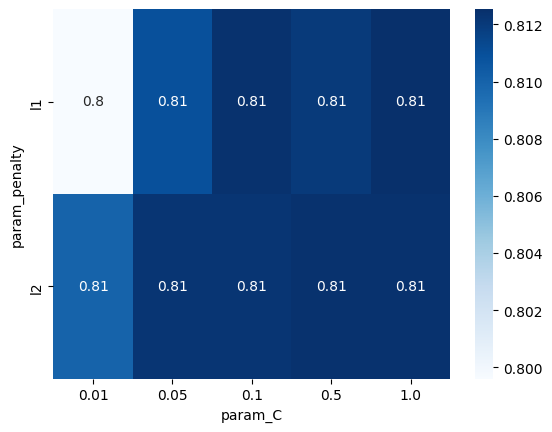

In [25]:
LR_models = pd.DataFrame(Grid_LR.cv_results_)
res = (LR_models.pivot(index='param_penalty', columns='param_C', values='mean_test_score'))
_ = sns.heatmap(res, annot=True, cmap='Blues')

### For KNN


In [26]:
# Choose k
parameters = {'n_neighbors': [1, 3, 5, 7, 9]}
Grid_KNN = GridSearchCV(KNeighborsClassifier(),parameters, cv = 5)
Grid_KNN.fit(X_train, y_train)
print_grid_search_metrics(Grid_KNN)

Best score: 0.8406666666666667
Best parameters set: 
	n_neighbors: 9


In [27]:
best_KNN_model = Grid_KNN.best_estimator_
best_KNN_model.predict(X_test)
best_KNN_model.score(X_test, y_test)

0.8368

### For Random Forest


In [28]:
# Choose number of trees
parameters = {'n_estimators': [60, 80, 100], 'max_depth': [1, 5, 10]}
Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv = 5)
Grid_RF.fit(X_train, y_train)
print_grid_search_metrics(Grid_RF)

Best score: 0.8639999999999999
Best parameters set: 
	max_depth: 10
	n_estimators: 100


In [29]:
best_RF_model = Grid_RF.best_estimator_
best_RF_model.predict(X_test)
best_RF_model.score(X_test, y_test)

0.8552

## Model Evaluation


### Confusion Matrix

In [30]:
# Precision = tp / (tp + fp)
# High precision: not many return users were predicted as churn users
# Recall = tp / (tp + fn)
# High recall: not many churn users were predicted as return users

def cal_evalution(classifier, cm):
  tn = cm[0, 0]
  fp = cm[0, 1]
  fn = cm[1, 0]
  tp = cm[1, 1]
  accuracy = (tp + tn) / (tp + tn + fp + fn)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f1 = 2 * precision * recall / (precision + recall)
  print(classifier)
  print('Accuracy: ', accuracy)
  print('Precision: ', precision)
  print('Recall: ', recall)
  print('F1: ', f1)
  print()

def print_confusion_matrices(confusion_matrices):
  class_names = ['Not', 'Churn']
  for cm in confusion_matrices:
    classifier, cm = cm[0], cm[1]
    cal_evalution(classifier, cm)

In [31]:
confusion_matrices = [
    ("Random Forest", confusion_matrix(y_test,best_RF_model.predict(X_test))),
    ("Logistic Regression", confusion_matrix(y_test,best_LR_model.predict(X_test))),
    ("K nearest neighbor", confusion_matrix(y_test, best_KNN_model.predict(X_test)))
]
print_confusion_matrices(confusion_matrices)

Random Forest
Accuracy:  0.8552
Precision:  0.788235294117647
Recall:  0.3948919449901768
F1:  0.5261780104712042

Logistic Regression
Accuracy:  0.8092
Precision:  0.5963855421686747
Recall:  0.1944990176817289
F1:  0.2933333333333334

K nearest neighbor
Accuracy:  0.8368
Precision:  0.7028112449799196
Recall:  0.343811394891945
F1:  0.46174142480211083



### ROC & AUC

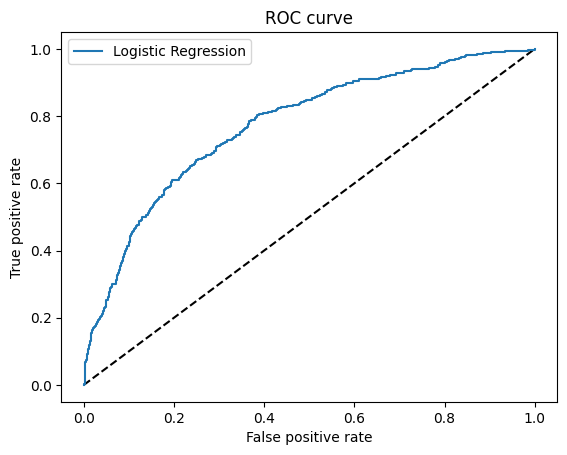

0.7722028104860872

In [32]:
# Logistic Regression
y_pred_LR = best_LR_model.predict_proba(X_test)[:, 1]
fpr_LR, tpr_LR, thresholds_LR = roc_curve(y_test, y_pred_LR)

best_LR_model.predict_proba(X_test)

# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_LR, tpr_LR, label='Logistic Regression')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# AUC
metrics.auc(fpr_LR, tpr_LR)

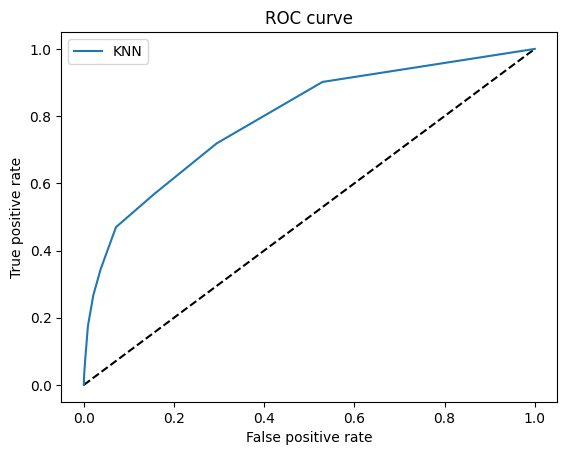

0.7932187969635461

In [33]:
# KNN
y_pred_KNN = best_KNN_model.predict_proba(X_test)[:, 1]
fpr_KNN, tpr_KNN, thresholds_KNN = roc_curve(y_test, y_pred_KNN)

best_KNN_model.predict_proba(X_test)

# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_KNN, tpr_KNN, label='KNN')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# AUC
metrics.auc(fpr_KNN, tpr_KNN)

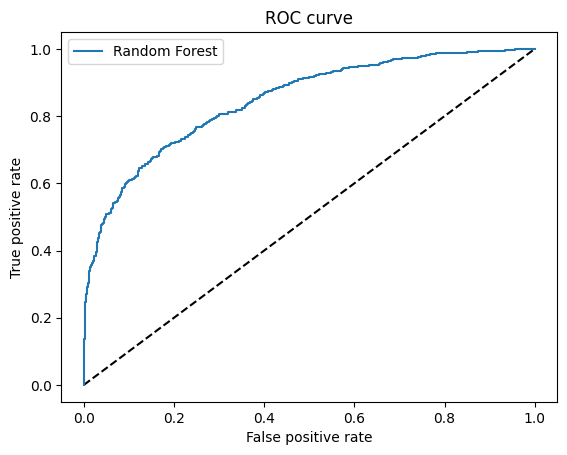

0.8473632327793341

In [34]:
# Random Forest
y_pred_RF = best_RF_model.predict_proba(X_test)[:, 1]
fpr_RF, tpr_RF, thresholds_RF = roc_curve(y_test, y_pred_RF)

best_RF_model.predict_proba(X_test)

# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_RF, tpr_RF, label='Random Forest')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# AUC
metrics.auc(fpr_RF, tpr_RF)

# Part 4: Model Extra Functionality

In [35]:
# Logistic Regression
X_with_corr = X_processed.copy()
X_with_corr['SalaryInRMB'] = X_with_corr['EstimatedSalary'] * 6.4
X_with_corr.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,SalaryInRMB
0,619,42,2,0.00,1,1,1,101348.88,1.0,0.0,0.0,1.0,0.0,648632.832
1,608,41,1,83807.86,1,0,1,112542.58,0.0,0.0,1.0,1.0,0.0,720272.512
2,502,42,8,159660.80,3,1,0,113931.57,1.0,0.0,0.0,1.0,0.0,729162.048
3,699,39,1,0.00,2,0,0,93826.63,1.0,0.0,0.0,1.0,0.0,600490.432
4,850,43,2,125510.82,1,1,1,79084.10,0.0,0.0,1.0,1.0,0.0,506138.240


In [36]:
# Add L2 regularization to logistic regression
# Check the coef for feature selection
np.random.seed()
scaler = StandardScaler()
X_l2 = scaler.fit_transform(X_with_corr)
LR_model_l2 = LogisticRegression(penalty="l2", C = 0.1, solver='liblinear', random_state=42)
LR_model_l2.fit(X_l2, y)
LR_model_l2.coef_[0]

indices = np.argsort(abs(LR_model_l2.coef_[0]))[::-1]

print ("Logistic Regression (L2) Coefficients")
for i in range(X_with_corr.shape[1]):
  print ("{0} : {1}".format(X_with_corr.columns[indices[i]],round(LR_model_l2.coef_[0][indices[i]], 4)))

Logistic Regression (L2) Coefficients
Age : 0.751
IsActiveMember : -0.5272
Geography_Germany : 0.2279
Balance : 0.162
Gender_Male : -0.13
Gender_Female : 0.13
Geography_France : -0.1207
Geography_Spain : -0.089
CreditScore : -0.0637
NumOfProducts : -0.0586
Tenure : -0.0452
HasCrCard : -0.0199
SalaryInRMB : 0.0137
EstimatedSalary : 0.0137


In [37]:
# Random Forest
X_RF = X_processed.copy()

X_RF.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1.0,0.0,0.0,1.0,0.0
1,608,41,1,83807.86,1,0,1,112542.58,0.0,0.0,1.0,1.0,0.0
2,502,42,8,159660.80,3,1,0,113931.57,1.0,0.0,0.0,1.0,0.0
3,699,39,1,0.00,2,0,0,93826.63,1.0,0.0,0.0,1.0,0.0
4,850,43,2,125510.82,1,1,1,79084.10,0.0,0.0,1.0,1.0,0.0


In [38]:
# Check feature importance of random forest for feature selection
forest = RandomForestClassifier()
forest.fit(X_RF, y)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature importance ranking by Random Forest Model:")
for ind in range(X.shape[1]):
  print ("{0} : {1}".format(X_RF.columns[indices[ind]],round(importances[indices[ind]], 4)))

Feature importance ranking by Random Forest Model:
Age : 0.2413
EstimatedSalary : 0.1474
CreditScore : 0.1428
Balance : 0.1416
NumOfProducts : 0.1265
Tenure : 0.0842
IsActiveMember : 0.0401
Geography_Germany : 0.0209
HasCrCard : 0.0185
Geography_France : 0.0101
